In [2]:
from pathlib import Path
freegroup_dimension = 4

path = Path('results', 'language-modeling', f'{freegroup_dimension}-free-group', 'gpt-2', f'{list(range(1, freegroup_dimension + 1))}')
path.mkdir(parents=True, exist_ok=True)

from os import environ
environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
from typing import List, Tuple, Dict, Any, Optional, Union
from transformers import PretrainedConfig, PreTrainedModel
from transformers.utils import ModelOutput
from torch import nn, stack
import transformers
from itertools import repeat
from dataclasses import dataclass

import torch
from torch.nn import functional as F
from copy import deepcopy

from transformers import TemperatureLogitsWarper, MaxLengthCriteria
from torch import full, device
from itertools import combinations

from freegroup import tools, sampling as smp



AggregatedConfig = Tuple[str, Dict[str, Any], bool, bool]

def aggregated_config(model_name, model_arguments, from_transformers, from_pretrained):
    return (model_name, model_arguments, from_transformers, from_pretrained)

def create_aggregated(config: AggregatedConfig):
    model_name, model_arguments, from_transformers, from_pretrained = config

    model_class = getattr(transformers, model_name) if from_transformers else globals()[model_name]
            
    if not from_pretrained:
        factory = lambda args: model_class(model_class.config_class(**args))
    else:
        factory = lambda args: model_class.from_pretrained(**args)
    
    return factory(model_arguments)


class EnsembleConfig(PretrainedConfig):

    def __init__(
        self, 
        ensemblee_configs: Optional[List[AggregatedConfig]] = None,
        ensemblee_weights: Optional[List[float]] = None,
        *args, **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.ensemblee_configs = ensemblee_configs 
        self.ensemblee_weights = ensemblee_weights


class EnsembleModel(PreTrainedModel):
    config_class = EnsembleConfig

    def __init__(self, config: EnsembleConfig, *args, **kwargs):
        super().__init__(config, *args, **kwargs)

        self.models = nn.ModuleList()
        for aggreagted_config in config.ensemblee_configs:
            self.models.append(create_aggregated(aggreagted_config))

    
    def forward(self, *args, **kwargs):
        output = {}
        for m in self.models:
            m_output = m(*args, **kwargs)
            for k, v in m_output.items():
                if not k in output:
                    output[k] = []
                output[k].append(v)
        return ModelOutput(output)


class EnsembleModelForCausalLM(EnsembleModel):
    def forward(self, *args, **kwargs):
        output = super().forward(*args, **kwargs)
        output['logits'] = stack([l * w for l, w in zip(output['logits'], self.config.ensemblee_weights)]).sum(dim=0)
        return output


class TransistedVocabularyConfig(PretrainedConfig):
    def __init__(
        self, model: AggregatedConfig, src: Dict[str, int], dst: Dict[str, int],
        *args, **kwargs
    ):
        super().__init__(*args, **kwargs)

        self.model = model
        self.src = src
        self.dst = dst

class TransistedVocabularyModel(PreTrainedModel):
    config_class = TransistedVocabularyConfig

    def __init__(self, config, *args, **kwargs):
        super().__init__(config)
        self.model = create_aggregated(config.model)

        self.register_buffer('transition', torch.zeros((len(config.src), len(config.dst)), dtype=torch.long))
        for key in config.src.keys():
            if key in config.dst:
                self.transition[config.src[key], config.dst[key]] = 1

        self.register_buffer('arange', torch.arange(len(config.src), dtype=torch.long))

    def forward(self, input_ids, *args, **kwargs):
        one_hot_encoded = F.one_hot(input_ids, num_classes = len(self.config.src))
        transited = one_hot_encoded @ self.transition
        input_ids = (transited * self.arange).sum(dim=-1)
        output = self.model(input_ids, *args, **kwargs)
        output['logits'] = output['logits'] @ self.transition.T.to(self.dtype)
        return output

def shifted_config(vocab, fgroup_dimension: int, shift: int):
    shifted = deepcopy(vocab)
    for gen in range(fgroup_dimension):
        original_idx, shifted_idx = gen + 1, (gen - shift) % fgroup_dimension + 1
        shifted[str(original_idx)] = vocab[str(shifted_idx)]
        shifted[str(-original_idx)] = vocab[str(-shifted_idx)]
    return shifted


def check_contain(sampled, n_generators: int, closures = None):
    if closures is None:
        closures = {(i,) : set() for i in range(1, n_generators + 1)}
        closures.update({tuple(range(1, n_generators + 1)) : set()})

    for word in sampled:
        for b, s in closures.items():
            if tools.is_from_singleton_normal_closure(list(b), word):
                s.add(tuple(word))
    return closures


def sampler(model, tokenizer, batch_size=100, tau=0.5, max_length=100):
    def new_batch():
        outputs = model.sample(
            full((batch_size, 1), tokenizer.bos_token_id).to(model.device),
            logits_processor = TemperatureLogitsWarper(tau),
            stopping_criteria = MaxLengthCriteria(max_length),
            pad_token_id = tokenizer.eos_token_id,
            eos_token_id = tokenizer.eos_token_id,
        )
        outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        return list(map(lambda x: list(map(int, x.split())), outputs))
    
    return smp.iterable_from_batches(new_batch)



In [7]:
from freegroup import tools, sampling as smp
from itertools import repeat

min_length = 0
max_length = 100
max_depth = 20

g = smp.normal_closure(
    list(range(1, freegroup_dimension + 1)),
    freegroup_dimension,
    'brackets',
    max_depth = max_depth,
)

g = map(tools.normalize, g)
g = filter(lambda x: len(x) > min_length and len(x) < max_length, g)

In [7]:
from freegroup import tools, sampling as smp
from itertools import repeat

min_length = 0
max_length = 200
max_depth = 10
n_multipliers = 3

generators = [[i] for i in range(1, freegroup_dimension + 1)]
g = smp.symmetric_commutant(
    generators,
    freegroup_dimension,
    n_multipliers,
    'brackets',
    max_depth = max_depth,
)

g = smp.join(*repeat(g, n_multipliers))
g = smp.subset(g)
g = smp.reduce(tools.multiply, g)

g = map(tools.normalize, g)
g = filter(lambda x: len(x) > min_length and len(x) < max_length, g)

100%|██████████| 1000/1000 [00:25<00:00, 39.48it/s]


(array([ 17.,  57.,  99., 135., 123., 132., 101.,  96., 121., 119.]),
 array([ 22. ,  39.6,  57.2,  74.8,  92.4, 110. , 127.6, 145.2, 162.8,
        180.4, 198. ]),
 <BarContainer object of 10 artists>)

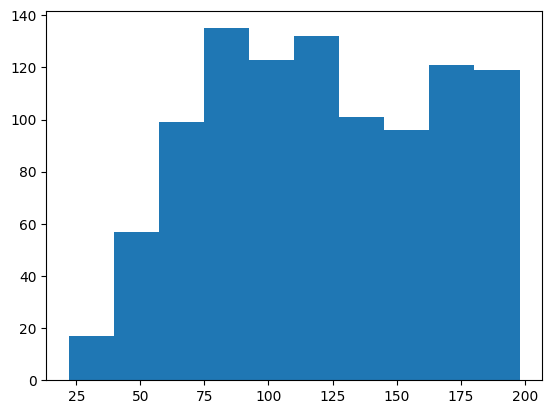

In [8]:
from tqdm import tqdm
from itertools import islice
from matplotlib import pyplot as plt

sampled = list(smp.take_unique(1000, g, verbose=True))
plt.hist(list(map(len, sampled)))

In [9]:
train_size, eval_size = int(10 ** 5), int(10 ** 4)

dataset = list(smp.take_unique(train_size + eval_size, g, verbose=True))
train_dataset, eval_dataset = dataset[:train_size], dataset[train_size:]

100%|██████████| 110000/110000 [00:53<00:00, 2039.04it/s]


In [12]:
from pickle import dump

prefix = '0-100-20'

train_dataset = list(map(str, train_dataset))
eval_dataset = list(map(str, eval_dataset))

(path / prefix).mkdir(parents=True, exist_ok=True)

with open(path / prefix / 'train_dataset.pkl', 'wb') as f:
    dump(train_dataset, f)

with open(path / prefix / 'eval_dataset.pkl', 'wb') as f:
    dump(eval_dataset, f)

In [13]:
from tokenizers import Tokenizer
from tokenizers import (
    normalizers, pre_tokenizers, models, processors, trainers
)
from tokenizers.trainers import WordLevelTrainer

from itertools import chain

tokenizer = Tokenizer(models.WordLevel(
    vocab = {str(x): i for i, x in enumerate(chain(range(-freegroup_dimension, 0), range(1, freegroup_dimension + 1)))}
))
tokenizer.add_special_tokens(['[BOS]', '[EOS]'])
tokenizer.normalizer = normalizers.Sequence([
    normalizers.Replace("[", ""),
    normalizers.Replace("]", ""),
])
tokenizer.pre_tokenizer = pre_tokenizers.Sequence([
    pre_tokenizers.CharDelimiterSplit(','),
    pre_tokenizers.WhitespaceSplit(),
])
tokenizer.post_processor = processors.TemplateProcessing(
    single="[BOS] $ [EOS]",
    special_tokens=[
        ("[BOS]", tokenizer.token_to_id('[BOS]')),
        ("[EOS]", tokenizer.token_to_id('[EOS]')),
    ]
)

tokenizer.save(str(path / 'tokenizer.json'))


In [14]:
from transformers import PreTrainedTokenizerFast
from pickle import load


tokenizer = PreTrainedTokenizerFast(tokenizer_file=str(path / 'tokenizer.json'), pad_token='[PAD]', bos_token='[BOS]', eos_token='[EOS]')

prefix = '0-100-20'

with open(path / prefix / 'train_dataset.pkl', 'rb') as f:
    train_dataset = load(f)

with open(path / prefix / 'eval_dataset.pkl', 'rb') as f:
    eval_dataset = load(f)


In [15]:
train_dataset = tokenizer(train_dataset)['input_ids']
eval_dataset = tokenizer(eval_dataset)['input_ids']

In [16]:
from transformers import GPT2Config, GPT2LMHeadModel

config = GPT2Config(
    vocab_size  = len(tokenizer.vocab),
    n_embd      = 128,
    n_layer     = 12,
    n_head      = 8,
)

model = GPT2LMHeadModel(config)

In [ ]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(str(path / 'checkpoint-15500'))

In [17]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [18]:
from transformers import Trainer
from freegroup import tools, sampling as smp


class TrainerWithSampling(Trainer):
    def evaluation_loop(self, dataloader, description: str, prediction_loss_only = None, ignore_keys = None, metric_key_prefix: str = "eval"):
        output = super().evaluation_loop(dataloader, description, prediction_loss_only, ignore_keys, metric_key_prefix)
        
        g = sampler(
            self.model,
            self.tokenizer,
            self.args.eval_sampling_batch_size,
            self.args.eval_sampling_tau,
            self.args.eval_sampling_max_length,
        )
        g = map(tools.normalize, g)
        g = smp.take_unique(200, g)
        g = smp.prefixes(g)
        
        container = check_contain(list(g), freegroup_dimension)
        for l in range(1, len(container.keys()) + 1):
            for subset in combinations(container.keys(), l):
                output.metrics[f'{metric_key_prefix}_' + '_'.join(map(str, subset))] = len(set.intersection(*[container[s] for s in subset]))
        return output

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    output_dir                  = str(path / prefix),
    evaluation_strategy         = 'epoch',
    learning_rate               = 5e-3,
    weight_decay                = 0.001,
    per_device_train_batch_size = 128,
    num_train_epochs            = 200,
    save_total_limit            = 10,
)

object.__setattr__(args, 'eval_sampling_batch_size', 100)
object.__setattr__(args, 'eval_sampling_tau', 0.5)
object.__setattr__(args, 'eval_sampling_max_length', 100)

trainer = TrainerWithSampling(
    model           = model,
    tokenizer       = tokenizer,
    args            = args,
    train_dataset   = train_dataset, 
    eval_dataset    = eval_dataset,
    data_collator   = data_collator,
)

trainer.train()

In [5]:
from transformers import PreTrainedTokenizerFast
from torch import cuda
from pathlib import Path

base_path = Path('results', 'language-modeling', '4-free-group', 'gpt-2')


tokenizer = PreTrainedTokenizerFast(tokenizer_file = str(base_path / '[[1, 2, 3, 4]]' / 'tokenizer.json'), pad_token='[PAD]', bos_token='[BOS]', eos_token='[EOS]')


config = EnsembleConfig(
    [
        aggregated_config(
            model_name          = 'GPT2LMHeadModel',
            model_arguments     = {'pretrained_model_name_or_path': str(base_path / '[[1, 2, 3, 4]]' / 'long' / 'checkpoint-7500')},
            from_transformers   = True,
            from_pretrained     = True,
        ),
        aggregated_config(
            model_name          = 'GPT2LMHeadModel',
            model_arguments     = {'pretrained_model_name_or_path': str(base_path / '[1, 2, 3, 4]' / '0-100-20' / 'checkpoint-3500')},
            from_transformers   = True,
            from_pretrained     = True,
        ),
    ],
    [1., 1.],
)
model = EnsembleModelForCausalLM(config).to('cuda')

In [ ]:
from freegroup import sampling as smp, tools

weight, tau = 0.8, 0.55

model.config.ensemblee_weights[-1] = weight
g = sampler(model, tokenizer, tau = tau, batch_size=50, max_length=100)
g = map(tools.normalize, g)
g = smp.prefixes(g)

def condition(x):
    for b in [[1], [2], [3], [4], [1, 2, 3, 4]]:
        if not tools.is_from_singleton_normal_closure(b, x):
            return False
    return True

g = filter(condition, g)

sampled = []
for w in smp.take_unique(1000, g, verbose=True):
    sampled.append(w)
